# Occupancy Estimation: Single Analysis for Three Interest Areas
**(Note: If the results are not satisfiable, we need to check how to further improve the accuracy of estimation of occupancy with Openpose.)**

* To run this note, you need to install Openpose following [Steps to Install Openpose in ComputeCanada Cluster](https://docs.google.com/document/d/1vQCQD2iet-K1ZAjTns2aEp-q7R-w8fCQ55jVzriWLV0/edit?usp=sharing)
* To set up Jupyter Notebook and submit jobs in Compute Canada Clusters, please refer to [Steps to Use Openpose Analyzing Video](https://docs.google.com/document/d/1tozpc-KpAHVjQOx5XkW0pDYbd8IKKCD45Omk-RvFNcg/edit?usp=sharing)

## Purpose
This note is to estimate occupancy in each of the [Three Interest Areas]() i.e.
1. Whole Interest Area
2. Core Interest Area
3. Margin Interest Area.

In [1]:
import os
os.system('module load nixpkgs/16.09  gcc/5.4.0  cuda/8.0.44  cudnn/7.0 opencv/3.3.0  boost/1.65.1 openblas/0.2.20 hdf5/1.8.18 leveldb/1.18 mkl-dnn/0.14 python/3.5.2')
os.system('cd ~')
os.system('source openposeEnv_Python3/bin/activate')
os.system('export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:$HOME/openpose_python_lib/lib:$HOME/openpose_python_lib/python/openpose:$HOME/caffe/build/lib:/cvmfs/soft.computecanada.ca/easybuild/software/2017/avx2/Compiler/gcc5.4/boost/1.65.1/lib')

0

### Maximun Estimation Accuracy
#### 1. Openpose Configureation
About maximum accuracy configuration, please refer to [Openpose: Maximum Accuracy Configuration](https://github.com/CMU-Perceptual-Computing-Lab/openpose/blob/master/doc/quick_start.md#maximum-accuracy-configuration).

Basically, here is the best configuration:
* params["net_resolution"] = "-1x736" (higher resolution might be better, but will run out of GPU memory)
* params["model_pose"] = "COCO" (better than "BODY_25" but needs 2 GPU)
* params["scale_gap"] = 0.25
* params["scale_number"] = 4

#### 2. Calculate Occupancy According to OpenPose Output


In [ ]:
# From Python
# It requires OpenCV installed for Python
import sys
import csv
import cv2
import os
from sys import platform
import argparse
import matplotlib.pyplot as plt

import pdb
from IPython.core.debugger import Tracer

# Remember to add your installation path here
# Option b
# If you run `make install` (default path is `/usr/local/python` for Ubuntu), you can also access the OpenPose/python module from there. This will install OpenPose and the python library at your desired installation path. Ensure that this is in your python path in order to use it.
sys.path.insert(0,r'/home/lingheng/openpose_python_lib/python/openpose') 

# Parameters for OpenPose. Take a look at C++ OpenPose example for meaning of components. Ensure all below are filled
try:
    from openpose import *
except:
    raise Exception('Error: OpenPose library could not be found. Did you enable `BUILD_PYTHON` in CMake and have this Python script in the right folder?')
params = dict()
params["logging_level"] = 3
params["output_resolution"] = "-1x-1"
params["net_resolution"] = "-1x736" # if crop video, this should be changged and must be mutplies of 16.
params["model_pose"] = "BODY_25"#"COCO"#"BODY_25"
params["alpha_pose"] = 0.6
params["scale_gap"] = 0.25
params["scale_number"] = 4
params["render_threshold"] = 0.05
# If GPU version is built, and multiple GPUs are available, set the ID here
params["num_gpu_start"] = 1
params["disable_blending"] = False
# Ensure you point to the correct path where models are located
params["default_model_folder"] = "/home/lingheng/openpose/models/"
# Construct OpenPose object allocates GPU memory
openpose = OpenPose(params)


In [3]:
# construct the argument parser and parse the arguments
args = dict()
args['video']='/home/lingheng/project/lingheng/ROM_Video_Process/ROM_raw_videos/test_video.mp4'
args['output_directory']='/home/lingheng/project/lingheng/ROM_Video_Process/Openpose_Video_Analysis_Code'

if args.get("video", None) is None:
    raise Error("No input video!!")
# otherwise, we are reading from a video file
else:
    camera = cv2.VideoCapture(args["video"])
# frames per second (fps) in the raw video
fps = camera.get(cv2.CAP_PROP_FPS)
frame_count = 1
print("Raw frames per second: {0}".format(fps))
# prepare to save video
(grabbed, frame) = camera.read()
## downsample frame
#downsample_rate = 0.5
#frame = cv2.resize(frame,None,fx=downsample_rate, fy=downsample_rate, interpolation = cv2.INTER_LINEAR)
# crop frame
original_h, original_w, channels= frame.shape
top_edge = int(original_h*(1/10))
down_edge = int(original_h*1)
left_edge = int(original_w*(1/5))
right_edge = int(original_w*(4/5))
frame_cropped = frame[top_edge:down_edge,left_edge:right_edge,:].copy() # must use copy(), otherwise slice only return address i.e. not hard copy

cropped_h, cropped_w, channels = frame_cropped.shape
fwidth = cropped_w 
fheight = cropped_h
print("Frame width:{}, Frame height:{}.".format(cropped_w , cropped_h))
# Define the polygon of Core Interest Area
point_1 = [int(0.17 * cropped_w), int(0.20 * cropped_h)]
point_2 = [int(0.17 * cropped_w), int(0.62 * cropped_h)]
point_3 = [int(0.44 * cropped_w), int(0.82 * cropped_h)]
point_4 = [int(0.61 * cropped_w), int(0.72 * cropped_h)]
point_5 = [int(0.61 * cropped_w), int(0.20 * cropped_h)]
core_interest_area_polygon = np.array([point_1,point_2,point_3,point_4,point_5])

# get output video file name
file_path = args["video"].split('/')
file_name, _= file_path[-1].split('.')
fourcc = cv2.VideoWriter_fourcc(*'XVID')

out_camera_frame_whole = cv2.VideoWriter(os.path.join(args['output_directory'],'{}_processed_whole.avi'.format(file_name)),fourcc, fps, (fwidth,fheight))

# get output estimated occupancy file name
out_occupancy_whole = os.path.join(args['output_directory'],'{}_processed_occupancy_whole.csv'.format(file_name))
out_occupancy_core = os.path.join(args['output_directory'],'{}_processed_occupancy_core.csv'.format(file_name))
out_occupancy_margin = os.path.join(args['output_directory'],'{}_processed_occupancy_margin.csv'.format(file_name))
with open(out_occupancy_whole, 'a') as csv_datafile:
    fieldnames = ['Time', 'Occupancy']
    writer = csv.DictWriter(csv_datafile, fieldnames = fieldnames)
    writer.writeheader()
with open(out_occupancy_core, 'a') as csv_datafile:
    fieldnames = ['Time', 'Occupancy']
    writer = csv.DictWriter(csv_datafile, fieldnames = fieldnames)
    writer.writeheader()    
with open(out_occupancy_margin, 'a') as csv_datafile:
    fieldnames = ['Time', 'Occupancy']
    writer = csv.DictWriter(csv_datafile, fieldnames = fieldnames)
    writer.writeheader()


Raw frames per second: 30.00063026534171
Frame width:1152, Frame height:972.


In [4]:
camera.get(cv2.CAP_PROP_FRAME_COUNT)

1428.0

## Process every frame in the video.
Overfall procudure:
1. Get new frame
2. Crop the frame to get Whole Interest Area
3. Use Openpose analyze the Whole Interest Area and get
   * keypoints_whole_interest_area: information on detected human [(detailes info)](https://github.com/CMU-Perceptual-Computing-Lab/openpose/blob/master/doc/output.md)
   * output_image_whole_interest_area: marked image
4. Calculate occupancy based on detected human in each of the Three Interest Areas
5. Write estimation of occupancy in each area into three separate files:
   * `test_video_processed_occupancy_whole.csv`: occupancy in Whole Interest Area
   * `test_video_processed_occupancy_core.csv`: occupancy in Core Interest Area
   * `test_video_processed_occupancy_margin.csv`: occupancy in Margin Interest Area
6. Write decorated frame to output video.
   * `test_video_processed_whole.avi`: decorated output video.

**Note:
When we calculate the location of the detected human, we choose the location of keypoint with the hightest confidence as the location of the detected huamn.**

Processing frame: 0
> <ipython-input-5-47aa40272e29>(33)<module>()
-> for people in keypoints_whole_interest_area:
(Pdb) keypoints_whole_interest_area
array([[[0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [3.0876762e+01, 4.1530106e+02, 6.6540468e-01],
        [4.4094513e+01, 4.1663654e+02, 6.3137144e-01],
        [4.6716839e+01, 4.3780423e+02, 4.7457364e-01],
        [4.1454395e+01, 4.5100604e+02, 1.4897123e-01],
        [1.7669554e+01, 4.1268906e+02, 5.9005630e-01],
        [4.4829831e+00, 4.3249658e+02, 2.7154326e-01],
        [5.7891574e+00, 4.4701697e+02, 7.6491520e-02],
        [3.6132339e+01, 4.6025397e+02, 6.4326036e-01],
        [3.6158779e+01, 4.9458575e+02, 6.3116223e-01],
        [3.6150780e+01, 5.2629749e+02, 5.7809651e-01],
        [1.6361681e+01, 4.6021124e+02, 5.6966090e-01],
        [1.2380327e+01, 4.9327603e+02, 5.8091313e-01],
        [1.2380680e+01, 5.2368555e+02, 4.9761504e-01],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 

(Pdb) c
> <ipython-input-5-47aa40272e29>(33)<module>()
-> for people in keypoints_whole_interest_area:
(Pdb) keypoints_whole_interest_area
array([[[0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [3.0878069e+01, 4.1530646e+02, 6.6519535e-01],
        [4.4086868e+01, 4.1664236e+02, 6.2876958e-01],
        [4.6714996e+01, 4.3780499e+02, 4.6877766e-01],
        [4.1458839e+01, 4.5101196e+02, 1.5582037e-01],
        [1.7676708e+01, 4.1269162e+02, 5.8917499e-01],
        [4.4834213e+00, 4.3250067e+02, 2.7275273e-01],
        [5.7908344e+00, 4.4701544e+02, 7.7307470e-02],
        [3.6135269e+01, 4.6025351e+02, 6.4442009e-01],
        [3.6165615e+01, 4.9457632e+02, 6.2963223e-01],
        [3.6157059e+01, 5.2628680e+02, 5.8030343e-01],
        [1.6367445e+01, 4.6021124e+02, 5.6989092e-01],
        [1.2388121e+01, 4.9326929e+02, 5.8110547e-01],
        [1.2387604e+01, 5.2367212e+02, 5.0096226e-01],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+0

(Pdb) c
> <ipython-input-5-47aa40272e29>(33)<module>()
-> for people in keypoints_whole_interest_area:
(Pdb) keypoints_whole_interest_area.shape[0]
5
(Pdb) c
> <ipython-input-5-47aa40272e29>(32)<module>()
-> pdb.set_trace()
(Pdb)  keypoints_whole_interest_area.shape[0]
5
(Pdb) c
> <ipython-input-5-47aa40272e29>(33)<module>()
-> for people in keypoints_whole_interest_area:
(Pdb)  keypoints_whole_interest_area.shape[0]
5
(Pdb) c
> <ipython-input-5-47aa40272e29>(32)<module>()
-> pdb.set_trace()
(Pdb)  keypoints_whole_interest_area.shape[0]
5
(Pdb) c
Processing frame: 10
> <ipython-input-5-47aa40272e29>(33)<module>()
-> for people in keypoints_whole_interest_area:
(Pdb)  keypoints_whole_interest_area.shape[0]
5
(Pdb) c
> <ipython-input-5-47aa40272e29>(32)<module>()
-> pdb.set_trace()
(Pdb)  keypoints_whole_interest_area.shape[0]
4
(Pdb) c
> <ipython-input-5-47aa40272e29>(33)<module>()
-> for people in keypoints_whole_interest_area:
(Pdb)  keypoints_whole_interest_area.shape[0]
4
(Pdb) c
> 

BdbQuit: 

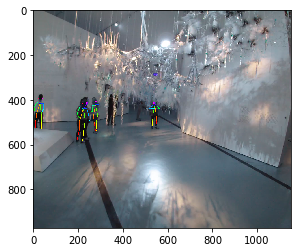

In [5]:
# loop over the frames of the video
total_frame_number = camera.get(cv2.CAP_PROP_FRAME_COUNT)
for frame_count in range(int(total_frame_number)):
    if frame_count % 5 == 0:
        print('Processing frame: {}'.format(frame_count))
    (grabbed, frame) = camera.read()
    if grabbed == True:
        time = camera.get(cv2.CAP_PROP_POS_MSEC) #Current position of the video file in milliseconds.
        ## downsample frame
        #frame = cv2.resize(frame,None,fx=downsample_rate, fy=downsample_rate, interpolation = cv2.INTER_LINEAR)
        # crop frame
        frame_cropped = frame[top_edge:down_edge,left_edge:right_edge,:].copy() # must use copy()
        #pdb.set_trace()
        # 1. Whole Interest Area
        # Output keypoints and the image with the human skeleton blended on it
        #    (num_people, 25_keypoints, x_y_confidence) = keypoints_whole_interest_area.shape
        keypoints_whole_interest_area, output_image_whole_interest_area = openpose.forward(frame_cropped, True)
        
        # 2. Core Interest Area
        core_interest_area_mask = np.zeros(frame_cropped.shape[:2], np.uint8)
        cv2.drawContours(core_interest_area_mask, [core_interest_area_polygon], -1, (255, 255, 255), -1, cv2.LINE_AA)
        core_interest_area = cv2.bitwise_and(output_image_whole_interest_area, frame_cropped, mask=core_interest_area_mask)
            
        # 3. Margin Interest Area
        margin_interest_area = cv2.bitwise_xor(output_image_whole_interest_area, core_interest_area)
        # TODO: infer occupancy from "keypoints_whole_interest_area"
        
        # draw the text and timestamp on the frame
        occupancy_whole = keypoints_whole_interest_area.shape[0]
        occupancy_core = 0
        occupancy_margin = 0
        pdb.set_trace()
        for people in keypoints_whole_interest_area:
            # Sort all keypoints and pick up the one with the highest confidence
            # Meaning of keypoints (https://github.com/CMU-Perceptual-Computing-Lab/openpose/blob/master/doc/output.md)
            ordered_keypoints = people[people[:,2].argsort(),:] # increasing order
            x, y = ordered_keypoints[-1][:2]
            #pdb.set_trace()
            # Choose the one with higher confidence to calculatate occupancy and location
            if cv2.pointPolygonTest(core_interest_area_polygon, (x, y), False) == 1:
                occupancy_core += 1
            else:
                occupancy_margin += 1
                
        cv2.drawContours(output_image_whole_interest_area, [core_interest_area_polygon], -1, (255, 255, 0), 2, cv2.LINE_AA)
        cv2.putText(output_image_whole_interest_area, "Whole Occupancy: {}, Core Occupancy: {}, Margin Occupancy: {}".format(occupancy_whole, occupancy_core, occupancy_margin), (10, 80), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
        cv2.putText(core_interest_area, "Core Occupancy: {}".format(occupancy_core), (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
        cv2.putText(margin_interest_area, "Margin Occupancy: {}".format(occupancy_margin), (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
        # save estimated occupancy data
        fieldnames = ['Time', 'Occupancy']
        with open(out_occupancy_whole, 'a') as csv_datafile:
            writer = csv.DictWriter(csv_datafile, fieldnames = fieldnames)
            writer.writerow({'Time':time, 'Occupancy': occupancy_whole})
        with open(out_occupancy_core, 'a') as csv_datafile:
            writer = csv.DictWriter(csv_datafile, fieldnames = fieldnames)
            writer.writerow({'Time':time, 'Occupancy': occupancy_core})
        with open(out_occupancy_margin, 'a') as csv_datafile:
            writer = csv.DictWriter(csv_datafile, fieldnames = fieldnames)
            writer.writerow({'Time':time, 'Occupancy': occupancy_margin})
        # save processed videos
        out_camera_frame_whole.write(output_image_whole_interest_area)
    else:
        # Pass this frame if cannot grab an image.
        print('Frame: {}, grabbed={} and frame={}'.format(frame_count, grabbed, frame))

## Result
After processing, we can get an output video as shown [here (YouTube Video)](https://youtu.be/1iPKDs9P1i4) and output estimation of occupancy in Three Interest Areas.

In [6]:
import pandas as pd
occupancy_whole = pd.read_csv('test_video_processed_occupancy_whole.csv', sep=',')
occupancy_core = pd.read_csv('test_video_processed_occupancy_core.csv', sep=',')
occupancy_margin = pd.read_csv('test_video_processed_occupancy_margin.csv', sep=',')

In [7]:
occupancy_whole

,Time,Occupancy
0,66.665266,4
1,99.997899,4
2,133.330532,4
3,166.663165,4
4,199.995798,4
5,233.328431,5
6,266.661064,5
7,299.993697,5
8,333.326331,5
9,366.658964,5


In [8]:
occupancy_core

,Time,Occupancy
0,66.665266,3
1,99.997899,3
2,133.330532,3
3,166.663165,3
4,199.995798,3
5,233.328431,4
6,266.661064,4
7,299.993697,4
8,333.326331,4
9,366.658964,4


In [9]:
occupancy_margin

,Time,Occupancy
0,66.665266,1
1,99.997899,1
2,133.330532,1
3,166.663165,1
4,199.995798,1
5,233.328431,1
6,266.661064,1
7,299.993697,1
8,333.326331,1
9,366.658964,1
